# Vision Transformers (ViT) from scratch in PyTorch

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision.transforms as transforms
import numpy as np
from PIL import Image

C:\ProgramData\Anaconda3\envs\game-RL\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [2]:
image = Image.open("n01498041_stingray.jpg")

# Define a transform to convert the image to tensor
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

# Convert the image to PyTorch tensor
image_tensor = transform(image)
image_tensor = image_tensor.unsqueeze(0)

# print the converted image tensor
print(image_tensor)
print(image_tensor.shape)

tensor([[[[0.0510, 0.1373, 0.1490,  ..., 0.0549, 0.1020, 0.0824],
          [0.1176, 0.1137, 0.0510,  ..., 0.0667, 0.0863, 0.1059],
          [0.1373, 0.1255, 0.0706,  ..., 0.0824, 0.0549, 0.0235],
          ...,
          [0.3176, 0.3765, 0.3059,  ..., 0.1451, 0.0392, 0.0824],
          [0.2745, 0.3255, 0.2824,  ..., 0.1294, 0.0706, 0.0824],
          [0.2745, 0.3137, 0.2471,  ..., 0.1882, 0.1412, 0.0980]],

         [[0.3490, 0.3725, 0.3216,  ..., 0.2863, 0.4667, 0.6000],
          [0.2863, 0.2392, 0.1882,  ..., 0.3804, 0.4824, 0.4627],
          [0.2353, 0.2667, 0.2549,  ..., 0.5020, 0.5647, 0.4196],
          ...,
          [0.3255, 0.3804, 0.2980,  ..., 0.3961, 0.2902, 0.3020],
          [0.2784, 0.3333, 0.2824,  ..., 0.4471, 0.2588, 0.2588],
          [0.1922, 0.2627, 0.1137,  ..., 0.3922, 0.4000, 0.3725]],

         [[0.3137, 0.1765, 0.1804,  ..., 0.2745, 0.3176, 0.4667],
          [0.1686, 0.1765, 0.2314,  ..., 0.3490, 0.4039, 0.3765],
          [0.2392, 0.2039, 0.2667,  ..., 0

In [3]:
image.show()

# Tasks to build ViT architecture

- Covert image into patches via learnable embeddings
<p>&nbsp;</p>
- Build transformer encoder layer matching described architecture:
    - x -> LayerNorm -> Multi-Head Attention -> + -> LayerNorm -> MultiLayerPerceptron -> Out
    - Include residual skip connections from input to "+" then from "+" to output 
<p>&nbsp;</p>
- Assemble model
    - Append learnable class embedding to position 0 and add positional embeddings to Transformer input
    - Stack 12 transformer encoder layers sequentially
<img src="https://production-media.paperswithcode.com/models/Screen_Shot_2021-02-14_at_2.26.57_PM_WBwCIco.png" width="667" height="376">

<h1>1: Patch Embeddings</h1>
<p>&nbsp;</p>
The embedding layer for Vision transformers are implemented by takeing the image $$x \in \mathbb{R}^{Height \times Width \times Channels}$$ as an input and segment it into N patches $$x_{p} \in \mathbb{R}^{N \times (Patch ^{2} \cdot Channels)}$$ Then we flatten the patches and use a linear projection to ensure its learnable (embedding) and can be fed into the transformer

In [4]:
class Flatten(nn.Module):
    
    def __init__(self, start_dim, end_dim):
        super().__init__()
        self.start_dim = start_dim
        self.end_dim = end_dim
        
    def __call__(self, x):
        return x.flatten(self.start_dim, self.end_dim)

In [5]:
# Utilise CNN module to pass over image and produce patches
class PatchEmbedding(nn.Module):

    def __init__(self, patch_size=16, in_chans=3, n_embd=768): # Hyperparameters from paper
        super().__init__()
        
        self.patch_size = patch_size
        # Conv2D layer acts as the learner
        self.patcher = nn.Conv2d(
                            in_channels = in_chans,
                            out_channels = n_embd,
                            kernel_size = patch_size, # kernal of patch size
                            stride = patch_size, # stride ensures patches dont overlap
                            padding = 0
                            )
        
        # flatten dims for transformer
        self.flatten = Flatten(start_dim=2, end_dim=3)
        
    def forward(self, x):
        # asserts suitable patch size is chosen
        img_res = x.shape[-1]
        assert img_res % self.patch_size == 0, f'input image size must be exactly divisable by patch size'
        
        # make and flatten patches for transformer
        x = self.patcher(x)
        x = self.flatten(x)
        
        
        return x.permute(0, 2, 1) # swaps last 2 dims to adhear to (batch, num_patches, Embedding[P^2•C])

In [6]:
test_emb = PatchEmbedding()
patched_x = test_emb(image_tensor)
patched_x.shape

torch.Size([1, 196, 768])

<h2>2: Transformer Encoder Layer</h2>

Components required:

- Single headed self-attention mechanism (Needs Linear layer)
- Concatenate multiple heads in parallel for multiheaded self attention
- Layer Norm
- MLP with one hidden layer
- Create Block

In [7]:
class Linear(nn.Module):
    
    def __init__(self, in_features: int, out_features: int, bias: bool=True) -> None:
        super().__init__()
        # Initialize weights and biases
        self.weight = nn.Parameter(torch.randn((in_features, out_features)) * (in_features**-0.5)) # in_features**-1 = K
        #use kaiming initialization to restrict weight dist between -sqrt(K) and sqrt(K)
        self.bias = nn.Parameter(torch.zeros(out_features)) if bias else None
        
    def __call__(self, x):
        # x•W + b
        self.out = x @ self.weight
        if self.bias is not None:
              self.out += self.bias
        return self.out

In [8]:
class Head(nn.Module):
    
    def __init__(self, head_size, n_embd=768, dropout=0.1):
        super().__init__()
        
        self.head_size = head_size

        # Initialize keys, queries, values, and dropout layers
        # Bias required to be true to match ViT pretrained parameters
            # Bias = False provides better and faster performance
        self.key = Linear(n_embd, head_size, bias=True)
        self.query = Linear(n_embd, head_size, bias=True)
        self.value = Linear(n_embd, head_size, bias=True)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        # apply self-attention as described in Attention is all you need
        
        # create keys and values
        k = self.key(x)
        q = self.query(x)
        
        # Produce weight matrix from q and k communication
        w = q @ k.transpose(-2, -1) * (self.head_size**-0.5)
        w = F.softmax(w, dim=-1)
        w = self.dropout(w)
        
        # use value layer to produce outputs
        v = self.value(x)
        out = w @ v
        return out

In [9]:
class MultiHeadAttention(nn.Module):
    
    def __init__(self, num_heads, head_size, n_embd=768, dropout=0.1):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # Concat head outputs along final dimention
        out = torch.cat([h(x) for h in self.heads], dim = -1)
        # Apply projection (not in paper but helps performance)
        out = self.dropout(self.proj(out))
        return out

In [10]:
class LayerNorm(nn.Module):
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(dim))
        self.beta = nn.Parameter(torch.zeros(dim))
  
    def __call__(self, x):
        # calculate the forward pass
        xmean = x.mean(1, keepdim=True) # batch mean
        xvar = x.var(1, keepdim=True) # batch variance
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        
        return self.out

In [11]:
def gelu(x):
    # gelu activation function
    return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))

In [12]:
class MLP(nn.Module):
    
    def __init__(self, n_embd, mlp_size=3072, dropout=0.1):
        super().__init__()
        
        self.net = nn.Sequential(
            Linear(n_embd, mlp_size),
            nn.GELU(),
            Linear(mlp_size, n_embd),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        
        return self.net(x)

In [13]:
class EncoderBlock(nn.Module):
    
    def __init__(self, n_embd, n_head, mlp_size=3072):
        super().__init__()
        head_size = n_embd // n_head
        # Multi-Head Attention
        self.sa = MultiHeadAttention(n_head, head_size)
        
        # MLP
        self.mlp = MLP(n_embd, mlp_size)
        
        # both layernorms
        self.ln1 = LayerNorm(n_embd)
        self.ln2 = LayerNorm(n_embd)
    
    def forward(self, x):
        # residual connections
        x = x + self.sa(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

<h2>3: Construct Model</h2>

In [14]:
class vit(nn.Module):
    
    def __init__(self, n_embd = 768, encoder_blocks = 12, output_size=1000, patch_size=16, img_size=224):
        super(vit, self).__init__()
        
        # Calculate number of patches
        n_patches = (img_size**2) // patch_size**2
        
        # CNN Patch Embedding
        self.embedding = PatchEmbedding(in_chans = 3, patch_size = 16, n_embd = 768)
        
        # Token needs to be applied across batch so is expanded in forward
        self.class_emb = nn.Parameter(torch.randn((1, 1, n_embd)), requires_grad=True)
        
        # Positional Embedding (no need for sin cos positional embedding implementation as n_embd is small see Appendix)
        self.pos_emb = nn.Parameter(torch.randn((1, n_patches+1, n_embd)), requires_grad=True)
        
        self.dropout = nn.Dropout(0.1)
        
        # Build encoder stack
        self.encoder = nn.Sequential(*[EncoderBlock(n_embd = 768, n_head = 12, mlp_size = 3072) for i in range(encoder_blocks)])
        
        # Layer Norm + MLP for final prediction
        self.norm = nn.LayerNorm(normalized_shape=n_embd)        
        self.out = nn.Linear(n_embd, output_size)
    
    def forward(self, x):
        
        batch_dim = x.shape[0]
        x = self.embedding(x)
        
        # Expand across batch
        class_tokn = self.class_emb.expand(batch_dim, -1, -1)
        x = torch.cat((x, class_tokn), 1)

        x = self.pos_emb + x

        x = self.dropout(x)
        x = self.encoder(x)

        # pass embedding token slice to final MLP
        x = self.out(self.norm(x[:, 0, :]))

        
        return x

In [15]:
x = vit()

def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [16]:
get_n_params(x)

86567656

In [17]:
!pip install torchinfo

from torchinfo import summary

summary(x)

Layer (type:depth-idx)                        Param #
vit                                           152,064
├─PatchEmbedding: 1-1                         --
│    └─Conv2d: 2-1                            590,592
│    └─Flatten: 2-2                           --
├─Dropout: 1-2                                --
├─Sequential: 1-3                             --
│    └─EncoderBlock: 2-3                      --
│    │    └─MultiHeadAttention: 3-1           2,362,368
│    │    └─MLP: 3-2                          4,722,432
│    │    └─LayerNorm: 3-3                    1,536
│    │    └─LayerNorm: 3-4                    1,536
│    └─EncoderBlock: 2-4                      --
│    │    └─MultiHeadAttention: 3-5           2,362,368
│    │    └─MLP: 3-6                          4,722,432
│    │    └─LayerNorm: 3-7                    1,536
│    │    └─LayerNorm: 3-8                    1,536
│    └─EncoderBlock: 2-5                      --
│    │    └─MultiHeadAttention: 3-9           2,362,368
│    │ 

We have achieved the correct number of trainable parameters to load pretrained weights

In [18]:
rand = torch.randn(32, 3, 224, 224)

ans = x(rand)

When passing in a dummy image batch we see outputs with expected dims (batch_size, classes)

In [19]:
print(ans.shape)
print([torch.argmax(ans[i,:]) for i in range(32)])

torch.Size([32, 1000])
[tensor(898), tensor(740), tensor(903), tensor(903), tensor(313), tensor(658), tensor(740), tensor(733), tensor(959), tensor(733), tensor(903), tensor(901), tensor(571), tensor(733), tensor(733), tensor(424), tensor(959), tensor(700), tensor(733), tensor(733), tensor(8), tensor(424), tensor(712), tensor(318), tensor(510), tensor(54), tensor(318), tensor(109), tensor(420), tensor(109), tensor(612), tensor(794)]


## Appendix
### Sin  Cos positional embedding (Attention Is All You Need)

As described in Attention Is All You Need we can encode the positions using the following formulas:

$$PE_{(pos,2i)} = \sin\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)$$
and
$$PE_{(pos,2i+1)} = \cos\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)$$
where pos is the position and i is the dimention. This allows the model to learn to learn by relative positions and allows the model to extrapolate to sequence lengths longer than the ones encountered
during training.

In [20]:
import numpy as np
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

In [21]:
class PositionalEncoding(nn.Module):
    
    def __init__(self, d_model, dropout=0.1, max_seq_len=100, device='cpu'):
        super().__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(dropout)
        
        pe = torch.zeros(max_seq_len, d_model).to(device)
        pos = torch.arange(0, max_seq_len).unsqueeze(1).float()
        
        two_i = torch.arange(0, d_model, step=2).float()
        div_term = torch.pow(10_000, two_i/torch.tensor([d_model])).float()
        pe[1:, 0::2] = torch.sin(pos/div_term)
        pe[1:, 1::2] = torch.sin(pos/div_term)
        
        pe = pe.unsqueeze(0)
        
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        
        pe = self.pe[:, :x.shape[1]].detatch() # not a learnable parameter
        x = x.add(pe)
        
        return self.dropout(x)

In [22]:
d_model = 512
positions = 100
z = 2/d_model

In [23]:
position_enc = np.array([
    [pos / np.power(10000, 2 * i / d_model) for i in range(d_model)] if (pos!=0) else np.zeros(d_model) for pos in range(0, positions)
])

position_enc[1:, 0::2] = np.sin(position_enc[1:, 0::2])
position_enc[1:, 1::2] = np.cos(position_enc[1:, 1::2])
#torch.cos

x = np.arange(0, positions)
emb = position_enc[x]
print(emb.shape)

(100, 512)


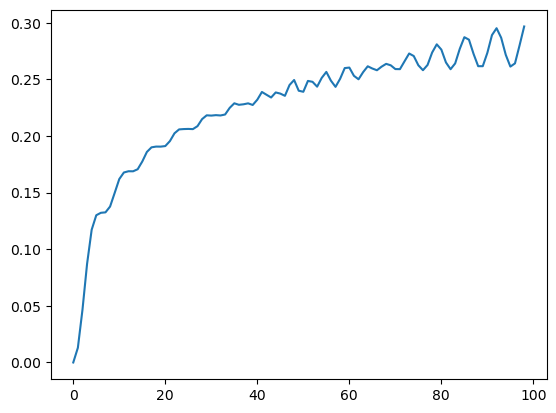

In [24]:
pos1 = position_enc[1]
pos2 = position_enc[2]
pos10 = position_enc[10]

cos = []
for i in range(1, 100):
    cos.append(cosine(position_enc[1], position_enc[i]))
    
plt.plot(cos)

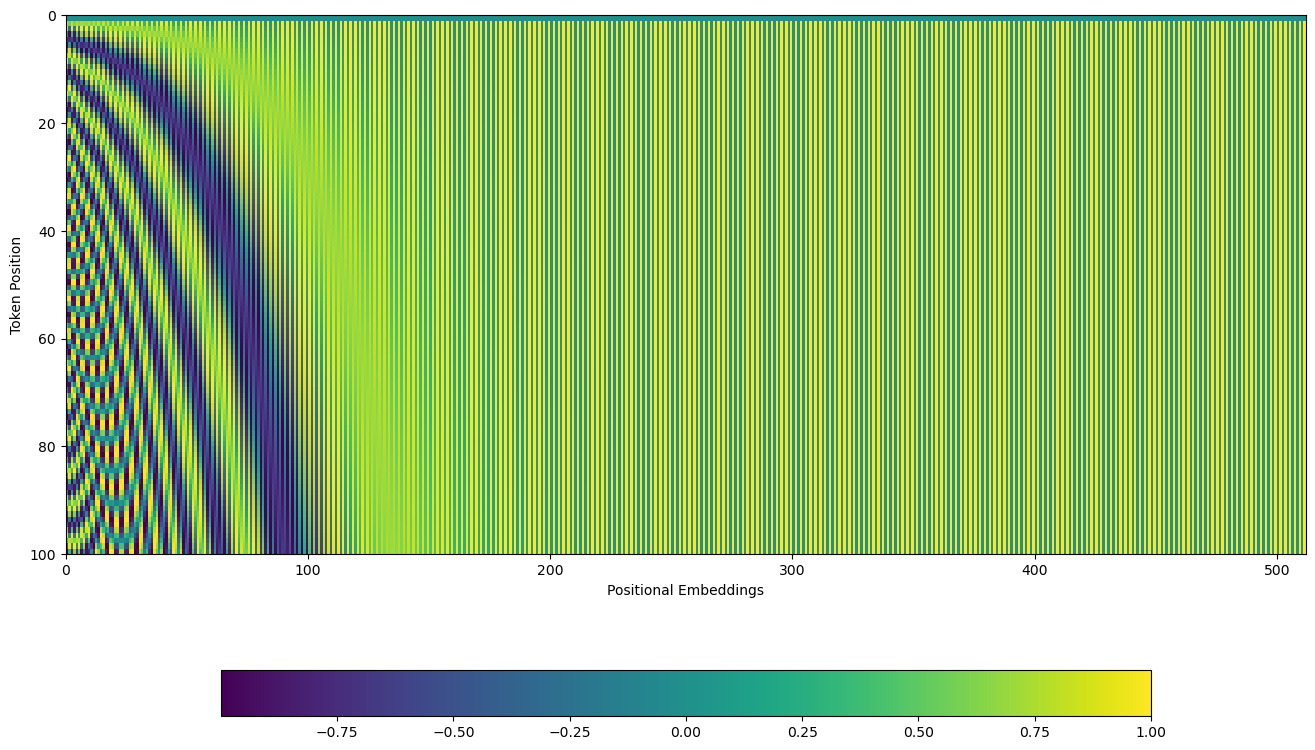

In [25]:
plt.figure(figsize=(16, 10))
plt.pcolormesh(emb)
plt.xlabel('Positional Embeddings')
plt.ylabel('Token Position')
plt.xlim(0, d_model)
plt.ylim(positions, 0)
plt.colorbar(orientation='horizontal', shrink=.75) 
plt.show()